In [1]:
# If we are on colab: this clones the repo and installs the dependencies
from pathlib import Path
from omegaconf import OmegaConf
from gluefactory.datasets import get_dataset
from gluefactory.utils.tensor import batch_to_device
import torch

torch.set_grad_enabled(True)
images = Path("assets")


from gluefactory.models import get_model
from matplotlib import pyplot as plt
import numpy as np

In [79]:
conf = OmegaConf.load("../gluefactory/configs/superpoint+simpleglue_homography_debug.yaml")

In [80]:
device= 'cpu'

In [81]:
data_conf = (conf.data)
dataset = get_dataset(data_conf.name)(data_conf)

[08/31/2025 14:42:32 gluefactory.datasets.base_dataset INFO] Creating dataset HomographyDataset
[08/31/2025 14:42:32 gluefactory.datasets.homographies INFO] Found 8 images in list file.


In [82]:
train_loader = dataset.get_data_loader("train", distributed=False)


In [83]:
model = get_model(conf.model.name)(conf.model).to(device)

Initialize state from lightglue for training


In [84]:
# train the model
torch.autograd.set_detect_anomaly(False)
tot_steps = 1
log_interval = 10
lr = 1e-10
params = [(n, p) for n, p in model.named_parameters() if p.requires_grad]
all_params = [p for n, p in params]
optimizer = torch.optim.Adam(all_params, lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
        lr, tot_steps, pct_start=0.01, cycle_momentum=False, anneal_strategy='linear')

step = 0
data = next(iter(train_loader))
data = batch_to_device(data, device, non_blocking=True)
data.update({'tr_logvar': False})
start_tr_logvar = tot_steps // 20
while(step < tot_steps):
    # for _, data in enumerate(train_loader):
        if step >= start_tr_logvar:
            data.update({'tr_logvar': True})
        model.train()
        optimizer.zero_grad()
        pred = model(data)
        losses, _ = model.loss(pred, data)
        loss = torch.mean(losses["total"])
        loss.backward()
        torch.nn.utils.clip_grad_norm_(all_params, conf.train.clip_grad)
        optimizer.step()
        scheduler.step()
        if step % log_interval == 0:
            print(f"Step {step}/{tot_steps}- lr: {scheduler.get_last_lr()} - Loss total: {loss.item()}, Last rpr Loss: {losses['last_rp'].item()}, Last lagvar Loss: {losses['last_logvar'].item()}")
        step += 1

Step 0/1- lr: [-1.0100929696969697e-10] - Loss total: 13895.2197265625, Last rpr Loss: 24295.8046875, Last lagvar Loss: -0.34753602743148804


In [113]:
def plot_p_and_var(tmp_n, kps_tgt, proj, r_square, p_tgt_src, log_var, w = 640, h = 480, tp = False):
    var = torch.exp(log_var).squeeze().detach().cpu().numpy()
    kps_tgt = kps_tgt.squeeze().detach().cpu().numpy().astype(int) # target

    if tp:
        r_square = r_square.transpose(-2, -3)
        p_tgt_src = p_tgt_src.transpose(-1, -2)
    r_square_n_x = r_square.squeeze().detach()[tmp_n, :, 0].cpu().numpy()
    r_square_n_y = r_square.squeeze().detach()[tmp_n, :, 1].cpu().numpy()
    # dist = F.softmax(logits[0, 0], dim=0).detach().cpu().numpy()
    dist = p_tgt_src.squeeze()[tmp_n].detach().cpu().numpy()

    print(f'Max categorical weight {dist.max()} and weight sum {dist.sum()}')
    print(f"Min residual_sq x {r_square_n_x.min()}, Max {r_square_n_x.max()}")
    print(f"Min residual_sq y {r_square_n_y.min()}, Max {r_square_n_y.max()}")
    print(f"Weigted residual_sq sum x {(r_square_n_x * dist).sum()}")
    print(f"Weigted residual_sq sum y {(r_square_n_y * dist).sum()}")

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.bar(kps_tgt[:, 0], dist, width=2, alpha=1)
    ax2.bar(kps_tgt[:, 1], dist, width=2, alpha=1)
    ax1.bar(kps_tgt[:, 0], r_square_n_x**0.5 / 100, width=1, color='r', alpha=0.1)
    ax2.bar(kps_tgt[:, 1], r_square_n_y**0.5 / 100, width=1, color='r', alpha=0.1)

    kp0_proj1_x = proj.squeeze()[tmp_n, 0].detach().cpu().numpy()
    kp0_proj1_y = proj.squeeze()[tmp_n, 1].detach().cpu().numpy() # point 80 projected in image 0
    variance_x = var[tmp_n, 0]
    variance_y = var[tmp_n, 1]
    from scipy.stats import norm

    print(f'Var x: {variance_x}, Var y: {variance_y}')
    w_x = np.linspace(0, w, 100)
    w_x = np.sort(np.append(w_x, kp0_proj1_x))
    w_y = norm.pdf(w_x, kp0_proj1_x, variance_x**0.5)
    h_x = np.linspace(0, h, 100)
    h_x = np.sort(np.append(h_x, kp0_proj1_y))
    h_y = norm.pdf(h_x, kp0_proj1_y, variance_y**0.5)

    # set xlim
    ax1.set_xlim([-10, w+10])
    ax2.set_xlim([-10, h+10])
    # set ylim
    ax1.set_ylim([0, 2.2])
    ax2.set_ylim([0, 2.2])
    ax1.plot(w_x, w_y, 'g--')
    ax2.plot(h_x, h_y, 'g--')

Max categorical weight 0.9977560639381409 and weight sum 1.0
Min residual_sq x 0.0007235230877995491, Max 17055.865234375
Min residual_sq y 0.01563406176865101, Max 8824.2470703125
Weigted residual_sq sum x 0.12058653682470322
Weigted residual_sq sum y 0.048723891377449036
Var x: 0.8233871459960938, Var y: 0.22803433239459991


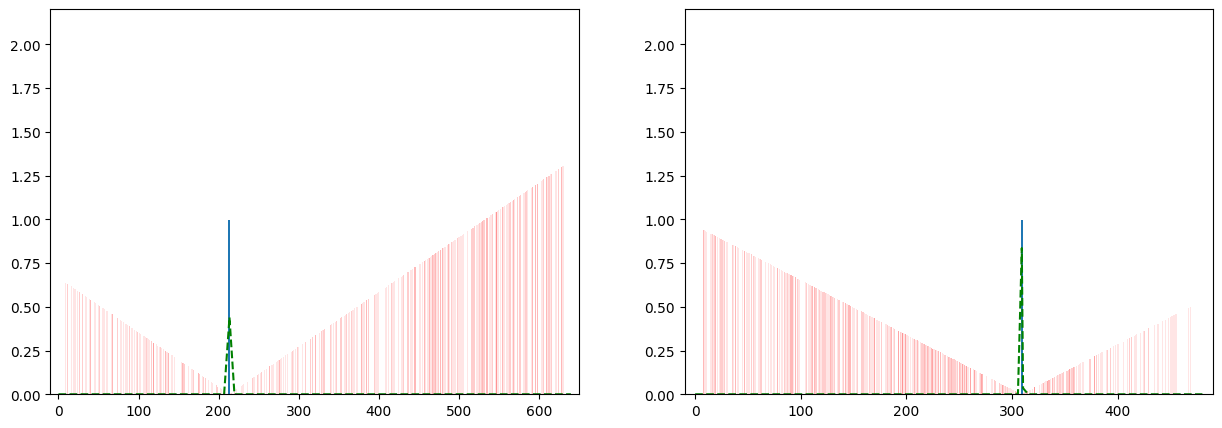

In [114]:
plot_p_and_var(0, pred['keypoints1'], pred['gt_proj_0to1'], pred['gt_res0_1_sq'], pred['p_rp_01'], pred['logvar_01'])

In [107]:
p_idx_01_of_N = torch.argmax(pred['p_rp_01'][0][0])
res_of_N = pred['gt_res0_1_sq'][0][0][p_idx_01_of_N]
proj_of_N = pred['keypoints1'][0][p_idx_01_of_N]
prob_of_N = pred['p_rp_01'][0][0][p_idx_01_of_N]
print(res_of_N)
print(proj_of_N)
print(prob_of_N)

tensor([0.0007, 0.0156])
tensor([213.5000, 309.5000])
tensor(0.9978, grad_fn=<SelectBackward0>)


Max categorical weight 0.26108354330062866 and weight sum 1.0
Min residual_sq x 40000.0, Max 40000.0
Min residual_sq y 40000.0, Max 40000.0
Weigted residual_sq sum x 39999.99609375
Weigted residual_sq sum y 39999.99609375
Var x: 1.0664219856262207, Var y: 0.27421027421951294


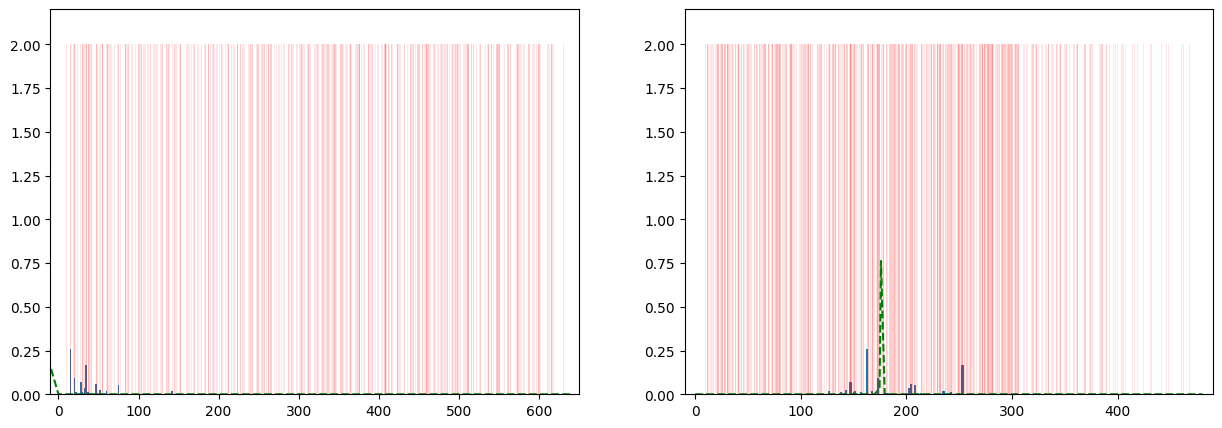

In [115]:
plot_p_and_var(0, pred['keypoints0'], pred['gt_proj_1to0'], pred['gt_res1_0_sq'], pred['p_rp_10'], pred['logvar_10'])

In [88]:
p_idx_10_of_N = torch.argmax(pred['p_rp_10'][0][0])
res_of_N = pred['gt_res1_0_sq'][0][0][p_idx_10_of_N]
proj_of_N = pred['keypoints0'][0][p_idx_10_of_N]
prob_of_N = pred['p_rp_10'][0][0][p_idx_10_of_N]
print(res_of_N)
print(proj_of_N)
print(prob_of_N)

tensor([40000., 40000.])
tensor([ 15.5000, 163.5000])
tensor(0.2611, grad_fn=<SelectBackward0>)


In [89]:
pred['keypoints0'].shape

torch.Size([1, 512, 2])

In [90]:

def plot_var_stats(var):
    print(f'Max and Min and Median var_01 x: {var[:, 0].max()}, {var[:, 0].min()}, {var[:, 0].median()}')
    print(f'Max and Min and Median var_01 y: {var[:, 1].max()}, {var[:, 1].min()}, {var[:, 1].median()}')
    var= var.numpy()
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.hist(var[:, 0], bins=100)
    ax2.hist(var[:, 1], bins=100)

In [91]:
pred['logvar_10'].squeeze()[:,:1].min(0)

torch.return_types.min(
values=tensor([-3.3013], grad_fn=<MinBackward0>),
indices=tensor([363]))

In [92]:
pred['logvar_10'].mean()

tensor(-0.2124, grad_fn=<MeanBackward0>)

Max and Min and Median var_01 x: 49.11041259765625, 0.03145487979054451, 0.9138740301132202
Max and Min and Median var_01 y: 12.117868423461914, 0.01071543712168932, 0.4072030782699585


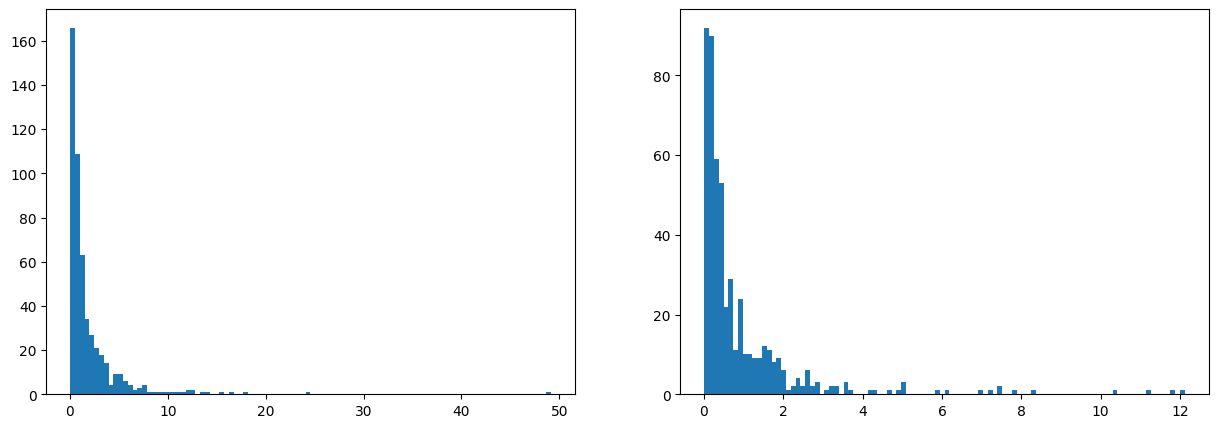

In [93]:
var_01 = torch.exp(pred['logvar_01']).squeeze().detach().cpu()
plot_var_stats(var_01)

Max and Min and Median var_01 x: 42.13420104980469, 0.03683410584926605, 1.5665099620819092
Max and Min and Median var_01 y: 14.696550369262695, 0.018375705927610397, 0.405086874961853


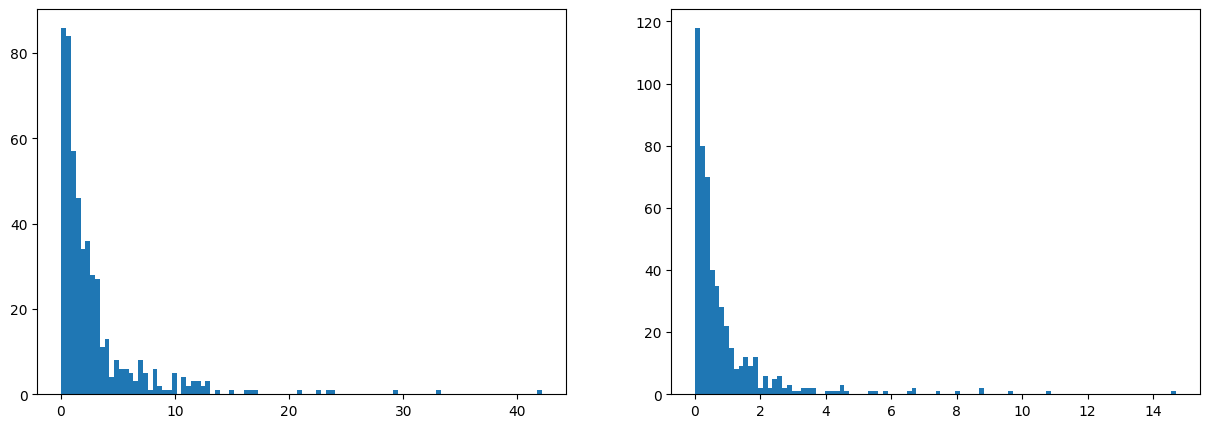

In [94]:
var_10 = torch.exp(pred['logvar_10']).squeeze().detach().cpu()
plot_var_stats(var_10)

In [95]:
import cv2

def draw_keypoints_cv(image, kps, color = (0, 255, 0), select_kp = None):
  if image.shape[1] == 3:  # RGB
    scale = image.new_tensor([0.299, 0.587, 0.114]).view(1, 3, 1, 1)
    image = (image * scale).sum(1, keepdim=True)
  image = image.squeeze().detach().cpu().numpy()
  image = (image * 255).astype(np.uint8)
  kps = kps.squeeze().detach().cpu().numpy()
    
  cv_kps= [cv2.KeyPoint(kp[0], kp[1], 1) for kp in kps]
  out_img = cv2.drawKeypoints(image, cv_kps, None, color=color, flags=0)

  if select_kp is not None:
    for kp in select_kp:
      cv2.circle(out_img, (int(kps[kp][0]), int(kps[kp][1])), 5, (255, 0, 0), -1)

  return out_img

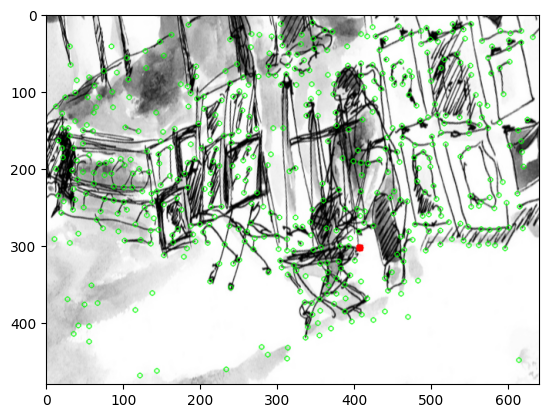

In [96]:
img0 = draw_keypoints_cv(data['view0']['image'], pred['keypoints0'], color=(0,255,0), select_kp=[266])
plt.imshow(img0)
plt.show()

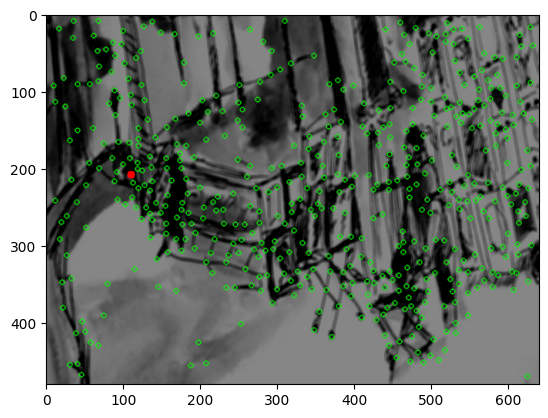

In [97]:
img1 = draw_keypoints_cv(data['view1']['image'], pred['keypoints1'], color=(0,255,0), select_kp=[0])
plt.imshow(img1)
plt.show()

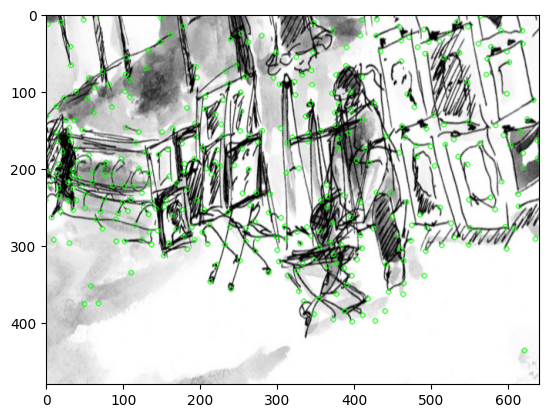

In [98]:
img1_0 = draw_keypoints_cv(data['view0']['image'], pred['gt_proj_1to0'], color=(0,255,0), select_kp=[0])
plt.imshow(img1_0)
plt.show()

In [99]:
pred['logvar_10'].shape

torch.Size([1, 512, 2])

tensor(414)


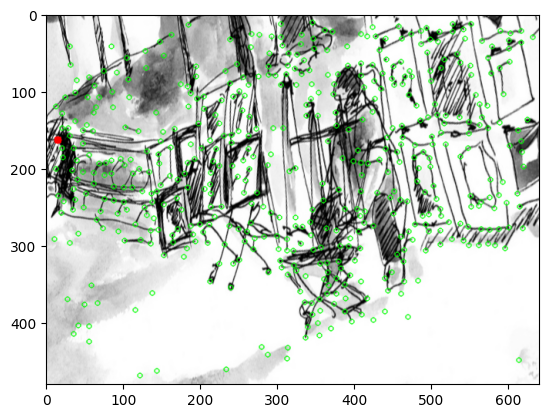

In [100]:
prob_1_0_of_Nth = pred['p_rp_10'][0][0]
est_Nth = torch.argmax(prob_1_0_of_Nth, -1)
print(est_Nth)
img0 = draw_keypoints_cv(data['view0']['image'], pred['keypoints0'], color=(0,255,0), select_kp=[est_Nth])
plt.imshow(img0)
plt.show()

In [101]:
def draw_stats(data):
    # arg: data Nx2
    print(f'Max and Min and Median x: {data[:, 0].max()}, {data[:, 0].min()}, {data[:, 0].median()}')
    print(f'Max and Min and Median y: {data[:, 1].max()}, {data[:, 1].min()}, {data[:, 1].median()}')
    data= data.numpy()
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    # draw x, y value as bar chart
    ax1.bar(np.arange(len(data)), data[:, 0])
    ax1.set_title('X values')
    ax2.bar(np.arange(len(data)), data[:, 1])
    ax2.set_title('Y values')

In [102]:
res0_1_sq = pred["gt_res0_1_sq"][0]
res1_0_sq = pred["gt_res1_0_sq"][0]

dist0_min = torch.sum(res0_1_sq, -1).min(-1).values
best_idx0 = torch.argmin(dist0_min)
worst_idx0 = torch.argmax(dist0_min)
dist1_min = torch.sum(res1_0_sq, -1).min(-1).values
best_idx1 = torch.argmin(dist1_min)
worst_idx1 = torch.argmax(dist1_min)


Max and Min and Median x: 17550.779296875, 0.00042630062671378255, 3161.739990234375
Max and Min and Median y: 9209.6376953125, 0.000861382985021919, 846.335693359375
Max and Min and Median x: 31735.71875, 0.0004091008158866316, 7122.5546875
Max and Min and Median y: 11349.63671875, 0.0007746750488877296, 879.6958618164062


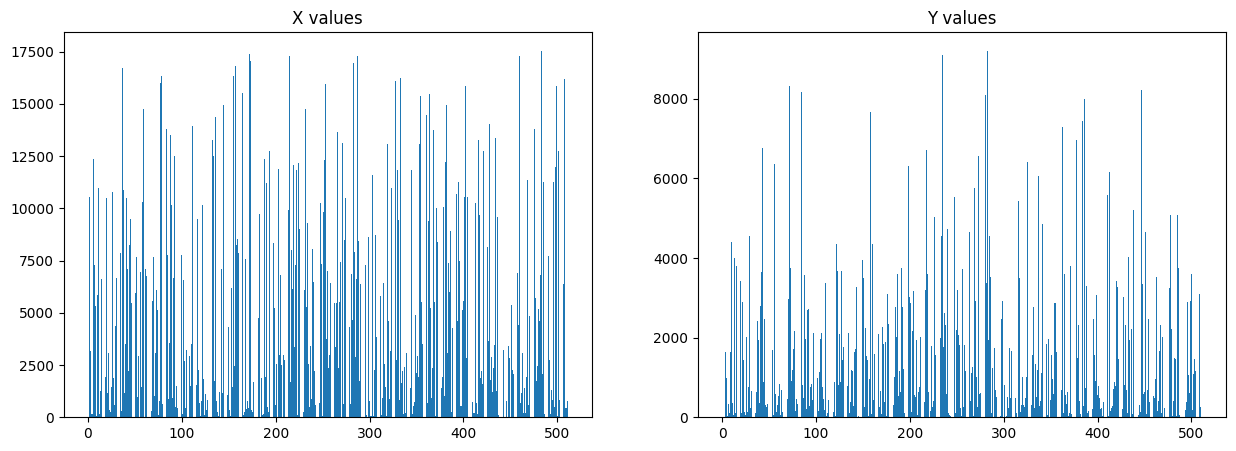

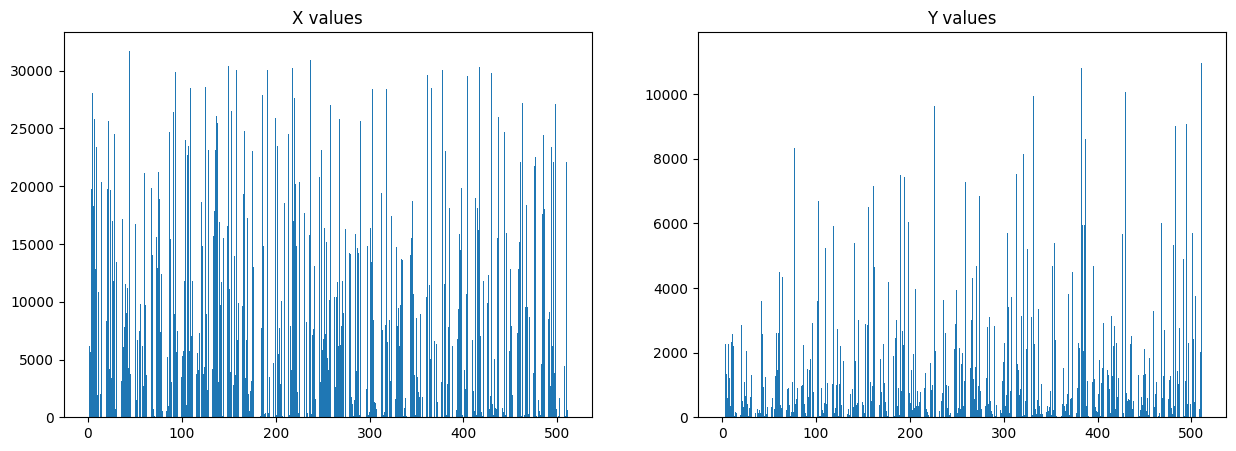

In [103]:
draw_stats(res0_1_sq[best_idx0, ...])
draw_stats(res1_0_sq[best_idx1, ...])

Max and Min and Median x: 40000.0, 40000.0, 40000.0
Max and Min and Median y: 40000.0, 40000.0, 40000.0
Max and Min and Median x: 40000.0, 40000.0, 40000.0
Max and Min and Median y: 40000.0, 40000.0, 40000.0


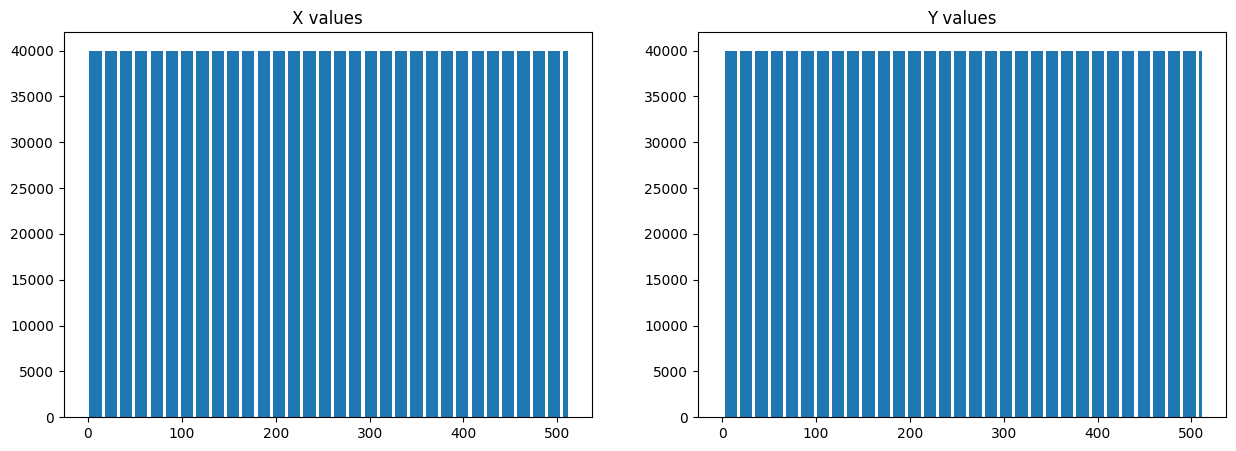

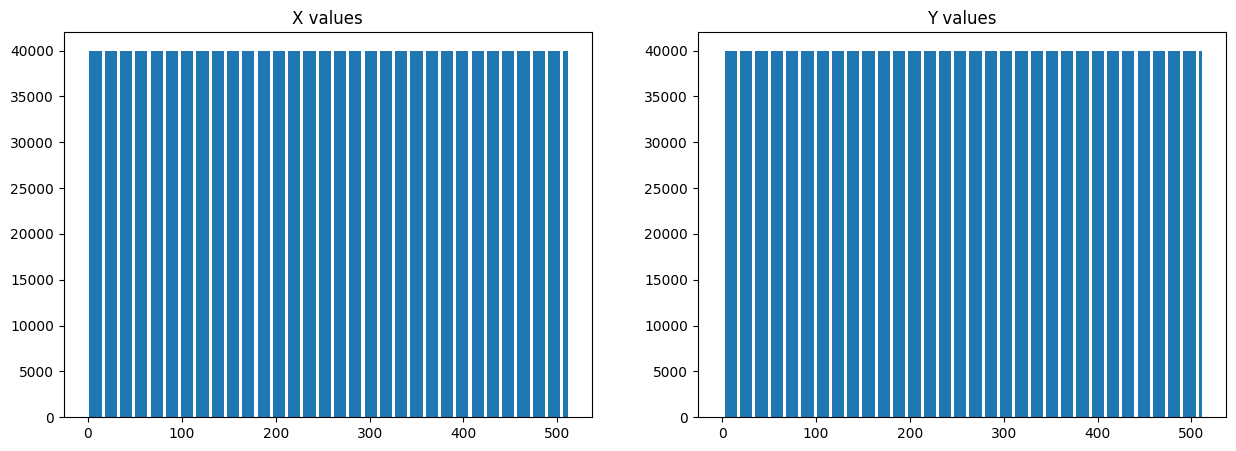

In [104]:
draw_stats(res0_1_sq[worst_idx0, ...])
draw_stats(res1_0_sq[worst_idx1, ...])

In [105]:
worst_idx1

tensor(0)